In [549]:
from functools import partial

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, f1_score, make_scorer
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [550]:
train_df = pd.read_csv('data/train.csv')
train_df.head()

,user_id,problem_id,attempts_range,level_type,points,tags,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds
0,user_232,prob_6507,1,B,1000.0,strings,53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935
1,user_3568,prob_2994,3,C,1500.0,"brute force,dp",133,118,0,NaN,0,1502200122,324.255,235.378,beginner,1454664414
2,user_1600,prob_5071,1,A,500.0,implementation,50,44,0,NaN,7,1504719542,343.177,229.358,beginner,1473490873
3,user_2256,prob_703,1,A,500.0,"brute force,implementation",271,233,23,Indonesia,40,1505175115,436.927,399.083,intermediate,1447736644
4,user_2321,prob_356,1,D,2000.0,"dfs and similar,trees",155,135,0,India,80,1505421849,492.546,472.190,advanced,1437724657


In [399]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155295 entries, 0 to 155294
Data columns (total 16 columns):
user_id                      155295 non-null object
problem_id                   155295 non-null object
attempts_range               155295 non-null int64
level_type                   154675 non-null object
points                       126220 non-null float64
tags                         139868 non-null object
submission_count             155295 non-null int64
problem_solved               155295 non-null int64
contribution                 155295 non-null int64
country                      117442 non-null object
follower_count               155295 non-null int64
last_online_time_seconds     155295 non-null int64
max_rating                   155295 non-null float64
rating                       155295 non-null float64
rank                         155295 non-null object
registration_time_seconds    155295 non-null int64
dtypes: float64(3), int64(7), object(6)
memory usage: 19.0+ M

### level_type

- Fillna with O category for now
- Make dummies

In [400]:
train_df.level_type.unique()

array(['B', 'C', 'A', 'D', 'E', 'I', 'G', 'J', 'F', 'K', 'H', 'L', 'M',
       nan, 'N'], dtype=object)

In [401]:
train_df.level_type.isnull().sum()

620

In [402]:
train_df.level_type.value_counts()

A    59718
B    40419
C    25876
D    13925
E     6197
F     2318
G     1544
H     1184
J     1015
I      955
K      759
L      480
M      227
N       58
Name: level_type, dtype: int64

In [403]:
def process_level(df):
    df.loc[:, 'level_type'] = df.level_type.fillna('O')
    df = pd.get_dummies(df, columns=['level_type'], prefix='level')
    return df

In [404]:
#train_df = process_level(train_df)
#train_df.head()

### Points

- replace negative points with nan
- Fillna values with mode for now. The thinking goes since points is not truly continous.

In [405]:
train_df.points.isnull().sum()

29075

In [406]:
train_df.points.describe()

count    126220.000000
mean        993.302369
std         568.115307
min          -1.000000
25%         500.000000
50%        1000.000000
75%        1500.000000
max        5000.000000
Name: points, dtype: float64

In [407]:
train_df[train_df.points == -1]

,user_id,problem_id,attempts_range,level_type,points,tags,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds
63981,user_1038,prob_5031,3,B,-1.0,NaN,928,888,45,Romania,229,1505579842,654.243,610.952,expert,1371299266


In [408]:
train_df.points.replace(-1, np.nan).describe()

count    126219.000000
mean        993.310246
std         568.110664
min           3.000000
25%         500.000000
50%        1000.000000
75%        1500.000000
max        5000.000000
Name: points, dtype: float64

In [409]:
train_df.points.value_counts().sort_index()

-1.0           1
 3.0         142
 4.0          39
 5.0           4
 6.0           1
 8.0          13
 10.0          1
 12.0          2
 20.0          1
 30.0         17
 40.0          2
 50.0          8
 60.0          4
 70.0          9
 250.0       791
 500.0     52605
 750.0      4456
 1000.0    32062
 1250.0     3008
 1500.0    16783
 1750.0     3147
 2000.0     7950
 2250.0     1099
 2500.0     3030
 2750.0      359
 3000.0      594
 3250.0       58
 3500.0       33
 5000.0        1
Name: points, dtype: int64

In [410]:
train_df.points.fillna(train_df.points.mode()).describe()

count    126220.000000
mean        993.302369
std         568.115307
min          -1.000000
25%         500.000000
50%        1000.000000
75%        1500.000000
max        5000.000000
Name: points, dtype: float64

In [411]:
train_df.points.fillna(train_df.points.mean()).describe()

count    155295.000000
mean        993.302369
std         512.178708
min          -1.000000
25%         500.000000
50%         993.302369
75%        1000.000000
max        5000.000000
Name: points, dtype: float64

In [412]:
def process_points(df):
    df.loc[df.points == -1, 'points'] = np.nan
    df.loc[:, 'points'] = df.points.fillna(df.points.mode()[0])
    return df

In [413]:
#train_df = process_points(train_df)
#train_df.points.describe()

### Tags

- find all tags
- replace na with empty strings
- make indicator columns from tags

In [414]:
def get_tags(df):
    all_tags = set([])
    for tags in df.tags.unique():
        if not isinstance(tags, float):
            for tag in tags.split(','):
                all_tags.add(tag)
    return all_tags

In [415]:
train_df.tags.isnull().sum()

15427

In [416]:
all_tags = get_tags(train_df)
all_tags

{'*special',
 '2-sat',
 'binary search',
 'bitmasks',
 'brute force',
 'chinese remainder theorem',
 'combinatorics',
 'constructive algorithms',
 'data structures',
 'dfs and similar',
 'divide and conquer',
 'dp',
 'dsu',
 'expression parsing',
 'fft',
 'flows',
 'games',
 'geometry',
 'graph matchings',
 'graphs',
 'greedy',
 'hashing',
 'implementation',
 'math',
 'matrices',
 'meet-in-the-middle',
 'number theory',
 'probabilities',
 'schedules',
 'shortest paths',
 'sortings',
 'string suffix structures',
 'strings',
 'ternary search',
 'trees',
 'two pointers'}

In [417]:
def tag_indicator(tag, x):  
    if tag in x:
        return 1
    else:
        return 0

In [418]:
counts = {}
for tag in all_tags:
    counts[tag] = train_df.tags.fillna('').apply(partial(tag_indicator, tag)).sum()

In [419]:
counts

{'*special': 875,
 '2-sat': 397,
 'binary search': 12083,
 'bitmasks': 2498,
 'brute force': 26920,
 'chinese remainder theorem': 65,
 'combinatorics': 2880,
 'constructive algorithms': 18051,
 'data structures': 13404,
 'dfs and similar': 10925,
 'divide and conquer': 1360,
 'dp': 16514,
 'dsu': 3120,
 'expression parsing': 484,
 'fft': 132,
 'flows': 344,
 'games': 2598,
 'geometry': 4064,
 'graph matchings': 781,
 'graphs': 6051,
 'greedy': 27578,
 'hashing': 1653,
 'implementation': 61567,
 'math': 32326,
 'matrices': 489,
 'meet-in-the-middle': 245,
 'number theory': 7871,
 'probabilities': 1422,
 'schedules': 80,
 'shortest paths': 1830,
 'sortings': 14904,
 'string suffix structures': 392,
 'strings': 10430,
 'ternary search': 443,
 'trees': 5265,
 'two pointers': 4432}

In [420]:
sorted(counts.items(), key=lambda x: x[1], reverse=True)

[('implementation', 61567),
 ('math', 32326),
 ('greedy', 27578),
 ('brute force', 26920),
 ('constructive algorithms', 18051),
 ('dp', 16514),
 ('sortings', 14904),
 ('data structures', 13404),
 ('binary search', 12083),
 ('dfs and similar', 10925),
 ('strings', 10430),
 ('number theory', 7871),
 ('graphs', 6051),
 ('trees', 5265),
 ('two pointers', 4432),
 ('geometry', 4064),
 ('dsu', 3120),
 ('combinatorics', 2880),
 ('games', 2598),
 ('bitmasks', 2498),
 ('shortest paths', 1830),
 ('hashing', 1653),
 ('probabilities', 1422),
 ('divide and conquer', 1360),
 ('*special', 875),
 ('graph matchings', 781),
 ('matrices', 489),
 ('expression parsing', 484),
 ('ternary search', 443),
 ('2-sat', 397),
 ('string suffix structures', 392),
 ('flows', 344),
 ('meet-in-the-middle', 245),
 ('fft', 132),
 ('schedules', 80),
 ('chinese remainder theorem', 65)]

In [421]:
def make_tag_columns(df, all_tags):
    columns = {}
    for tag in all_tags:
        name = tag.replace(' ', '-')
        columns[name] = df.tags.apply(partial(tag_indicator, tag))
    return pd.DataFrame(columns)

In [422]:
def process_tags(df):
    all_tags = get_tags(df)
    df.loc[:, 'tags'] = df.tags.fillna('')
    tag_columns = make_tag_columns(df, all_tags)
    df = pd.concat([df, tag_columns], axis=1).drop(['tags'], axis=1)
    return df

In [423]:
#train_df = process_tags(train_df)
#train_df.head()

### submission_count

In [424]:
train_df.submission_count.describe()

count    155295.000000
mean        372.235680
std         398.204943
min           1.000000
25%         118.000000
50%         237.000000
75%         480.000000
max        4570.000000
Name: submission_count, dtype: float64

In [425]:
def process_submission_count(df):
    return df

In [426]:
#train_df = process_submission_count(train_df)
#train_df.head()

### problem_solved

In [427]:
train_df.problem_solved.dtype

dtype('int64')

In [428]:
train_df.problem_solved.describe()

count    155295.000000
mean        336.078695
std         377.378519
min           1.000000
25%          99.000000
50%         209.000000
75%         428.000000
max        4476.000000
Name: problem_solved, dtype: float64

In [429]:
def process_problem_solved(df):
    return df

In [430]:
#train_df = process_problem_solved(train_df)
#train_df.head()

### contribution

-

In [431]:
train_df.contribution.describe()

count    155295.000000
mean          5.493718
std          19.076626
min         -64.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         171.000000
Name: contribution, dtype: float64

In [432]:
def process_contribution(df):
    return df

In [433]:
#train_df = process_contribution(train_df)
#train_df.head()

### country

- Has null values. How to fill? Does it make sense to do one hot encoding?
- Dropping for now, looks bad for algorithm until I find someway to use this, maybe only some top countries?

- Now adding countries to the set, will pick top few countries or use PCA on all?

In [434]:
train_df.country.describe()

count     117442
unique        79
top        India
freq       30155
Name: country, dtype: object

In [435]:
train_df.country.unique()

array(['Bangladesh', nan, 'Indonesia', 'India', 'Egypt', 'Brazil', 'China',
       'Vietnam', 'Romania', 'Czechia', 'Spain', 'Japan', 'Russia',
       'Ukraine', 'South Korea', 'Kazakhstan', 'Iran', 'Croatia',
       'Moldova', 'Colombia', 'Thailand', 'Malaysia', 'United States',
       'Syria', 'Taiwan', 'Macedonia', 'Belarus', 'Mexico', 'Mongolia',
       'Tajikistan', 'Georgia', 'Turkmenistan', 'Hong Kong', 'Costa Rica',
       'Peru', 'Lithuania', 'Argentina', 'Bulgaria', 'Venezuela', 'Poland',
       'Uzbekistan', 'Germany', 'Tunisia', 'Morocco', 'Azerbaijan',
       'Jordan', 'Armenia', 'Canada', 'Israel', 'Cuba', 'Chile',
       'Kyrgyzstan', 'Finland', 'Bosnia and Herzegovina',
       'Trinidad and Tobago', 'Hungary', 'Bolivia', 'Estonia', 'Serbia',
       'Austria', 'North Korea', 'Singapore', 'United Kingdom', 'Belgium',
       'Italy', 'Norway', 'Slovakia', 'Switzerland', 'Australia', 'Latvia',
       'France', 'Philippines', 'Laos', 'Christmas Island', 'South Africa',
     

In [436]:
train_df.country.isnull().sum()

37853

In [437]:
train_df.country.value_counts()

India                     30155
Bangladesh                15869
Russia                    13088
China                      7766
Egypt                      5193
Kazakhstan                 3553
Vietnam                    3079
Brazil                     3048
Iran                       3036
Ukraine                    2813
Belarus                    2459
Japan                      2273
Syria                      2017
United States              2015
Romania                    1899
Poland                     1591
Uzbekistan                 1327
Taiwan                     1166
South Korea                1146
Croatia                    1006
Indonesia                   910
Mexico                      847
Jordan                      698
Moldova                     625
Georgia                     586
Peru                        547
Argentina                   527
Hong Kong                   374
Bolivia                     363
Germany                     347
                          ...  
Italy   

In [438]:
def process_country(df):
    imp_countries = list((df.country.value_counts()).nlargest(16).index)
    countries = pd.get_dummies(df.country)[imp_countries]
    df = pd.concat([df, countries], axis=1)
    return df

In [439]:
#train_df = process_country(train_df)
#train_df.head()

### Follower_count

In [440]:
train_df.follower_count.dtype

dtype('int64')

In [441]:
train_df.follower_count.describe()

count    155295.000000
mean         61.064406
std         258.997551
min           0.000000
25%           7.000000
50%          20.000000
75%          52.000000
max       10575.000000
Name: follower_count, dtype: float64

In [442]:
def process_follower_count(df):
    return df

In [443]:
#train_df = process_follower_count(train_df)
#train_df.head()

### last_online_time_seconds

In [444]:
train_df.last_online_time_seconds.dtype

dtype('int64')

In [445]:
train_df.last_online_time_seconds.describe()

count    1.552950e+05
mean     1.503666e+09
std      3.867762e+06
min      1.484239e+09
25%      1.504118e+09
50%      1.505289e+09
75%      1.505560e+09
max      1.505595e+09
Name: last_online_time_seconds, dtype: float64

In [446]:
train_df.last_online_time_seconds.min()

1484238900

In [447]:
train_df.last_online_time_seconds.head()

0    1503633778
1    1502200122
2    1504719542
3    1505175115
4    1505421849
Name: last_online_time_seconds, dtype: int64

In [448]:
train_df.last_online_time_seconds.corr(train_df.attempts_range)

0.010567629778283742

In [449]:
def process_online(df):
    return df

In [450]:
#train_df = process_online(train_df)
#train_df.head()

### max_rating

In [451]:
train_df.max_rating.dtype

dtype('float64')

In [452]:
train_df.max_rating.describe()

count    155295.000000
mean        407.525560
std          99.670629
min         303.899000
25%         323.394000
50%         383.028000
75%         468.463000
max         983.085000
Name: max_rating, dtype: float64

In [453]:
def process_max_rating(df):
    return df

In [454]:
#train_df = process_max_rating(train_df)
#train_df.head()

### rating

In [455]:
train_df.rating.describe()

count    155295.000000
mean        368.623667
std         112.046565
min           0.000000
25%         288.131000
50%         356.078000
75%         445.814000
max         911.124000
Name: rating, dtype: float64

In [456]:
def process_rating(df):
    return df

In [457]:
#train_df = process_rating(train_df)
#train_df.head()

### rank

In [458]:
train_df['rank'].describe()

count           155295
unique               4
top       intermediate
freq             66510
Name: rank, dtype: object

In [459]:
train_df['rank'].unique()

array(['beginner', 'intermediate', 'advanced', 'expert'], dtype=object)

In [460]:
def process_rank(df):    
    df = pd.get_dummies(df, columns=['rank'], prefix='rank')
    return df

In [461]:
#train_df = process_rank(train_df)
#train_df.head()

### registration_time_seconds

In [462]:
train_df.registration_time_seconds.describe()

count    1.552950e+05
mean     1.427513e+09
std      5.033908e+07
min      1.264761e+09
25%      1.408458e+09
50%      1.442762e+09
75%      1.464692e+09
max      1.484236e+09
Name: registration_time_seconds, dtype: float64

In [463]:
def process_registration(df):
    return df

In [464]:
#train_df = process_registration(train_df)
#train_df.head()

### Process Complete Dataset

In [723]:
def process(df):
    df = process_level(df)
    df = process_points(df)
    df = process_tags(df)
    df = process_submission_count(df)
    df = process_problem_solved(df)
    df = process_contribution(df)
    df = process_contribution(df)
    df = process_country(df)
    df = process_follower_count(df)
    df = process_online(df)
    df = process_max_rating(df)
    df = process_rating(df)
    df = process_rank(df)
    df = process_registration(df)
    df.loc[:, 'online'] = df['last_online_time_seconds'] - df['registration_time_seconds']
    df.loc[:, 'accuracy'] = df['problem_solved'] - df['submission_count']
    df.loc[:, 'level_1'] = df[['level_A', 'level_B']].sum(axis=1)
    df.loc[:, 'level_2'] = df[['level_C', 'level_D', 'level_E', 'level_F']].sum(axis=1)
    df.loc[:, 'level_3'] = df[['level_G', 'level_H', 'level_I', 'level_J', 'level_K', 'level_L', 'level_M', 'level_N', 'level_O']].sum(axis=1)
    df.loc[:, 'rank_intermediate'] = df[['rank_intermediate', 'rank_advanced', 'rank_expert']]
    df.loc[:, 'small_categories'] = df[['string-suffix-structures', '2-sat', 'meet-in-the-middle', 'fft', 'schedules', 'chinese-remainder-theorem']].sum(axis=1)
    
    df = df.drop(['user_id', 'problem_id', 'country',
                  'last_online_time_seconds', 'registration_time_seconds',
                'problem_solved', 'submission_count', 'rank_advanced', 'rank_expert'], axis=1)
    levels_drop = ['level_{}'.format(alpha) for alpha in 'ABCDEFGHIJKLMNO']
    df = df.drop(levels_drop, axis=1)
    df.drop(['string-suffix-structures',
             '2-sat',
             'meet-in-the-middle',
             'fft',
             'schedules',
             'chinese-remainder-theorem'], axis=1)

    
    return df

In [724]:
train_df = pd.read_csv('data/train.csv')

In [725]:
train_df = process(train_df)
train_df.head()

,attempts_range,points,contribution,follower_count,max_rating,rating,*special,2-sat,binary-search,bitmasks,...,Romania,Poland,rank_beginner,rank_intermediate,online,accuracy,level_1,level_2,level_3,small_categories
0,1,1000.0,0,1,307.913,206.709,0,0,0,0,...,0,0,1,0,71522843,-6,1,0,0,0
1,3,1500.0,0,0,324.255,235.378,0,0,0,0,...,0,0,1,0,47535708,-15,0,1,0,0
2,1,500.0,0,7,343.177,229.358,0,0,0,0,...,0,0,1,0,31228669,-6,1,0,0,0
3,1,500.0,23,40,436.927,399.083,0,0,0,0,...,0,0,0,1,57438471,-38,1,0,0,0
4,1,2000.0,0,80,492.546,472.190,0,0,0,0,...,0,0,0,0,67697192,-20,0,1,0,0


In [726]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155295 entries, 0 to 155294
Data columns (total 66 columns):
attempts_range               155295 non-null int64
points                       155295 non-null float64
contribution                 155295 non-null int64
follower_count               155295 non-null int64
max_rating                   155295 non-null float64
rating                       155295 non-null float64
*special                     155295 non-null int64
2-sat                        155295 non-null int64
binary-search                155295 non-null int64
bitmasks                     155295 non-null int64
brute-force                  155295 non-null int64
chinese-remainder-theorem    155295 non-null int64
combinatorics                155295 non-null int64
constructive-algorithms      155295 non-null int64
data-structures              155295 non-null int64
dfs-and-similar              155295 non-null int64
divide-and-conquer           155295 non-null int64
dp              

In [727]:
X, y = train_df.drop('attempts_range', axis=1).copy(), train_df.attempts_range.copy()

In [728]:
X.shape

(155295, 65)

In [729]:
y.shape

(155295,)

### Training and testing data

In [730]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

### Generate test dataset

In [731]:
def make_submission(model, test_df, fname=None):
    submission = test_df[['ID']].copy()
    attempts = model.predict(test_df.drop('ID', axis=1))
    submission.loc[:, 'attempts_range'] = attempts
    if fname:
        submission.to_csv('data/submissions/{}'.format(fname), index=False)
    return submission

In [732]:
test_df = process(pd.read_csv('data/test.csv'))
test_df.head()

,ID,points,contribution,follower_count,max_rating,rating,*special,2-sat,binary-search,bitmasks,...,Romania,Poland,rank_beginner,rank_intermediate,online,accuracy,level_1,level_2,level_3,small_categories
0,user_856_prob_5822,500.0,0,35,393.062,362.959,0,0,0,0,...,0,0,0,1,81070769,-43,0,0,1,0
1,user_2642_prob_2334,500.0,0,8,307.053,146.502,0,0,0,0,...,0,0,1,0,65576834,-10,1,0,0,0
2,user_2557_prob_2920,500.0,0,76,321.674,241.399,0,0,0,0,...,0,0,1,0,109419135,-84,1,0,0,0
3,user_1572_prob_4598,1000.0,0,29,473.050,454.989,0,0,0,0,...,0,0,0,1,81386750,-22,1,0,0,0
4,user_295_prob_6139,500.0,0,3,455.275,448.108,0,0,1,0,...,0,0,0,1,40284363,-24,1,0,0,0


### Evaluation Metric

In [733]:
scorer = partial(f1_score, average='weighted')
grid_scorer = make_scorer(f1_score, average='weighted')

### Base Classifier - GaussianNB

#### Try 1
- MinMaxScaling
- Model - GaussianNB
- .334

In [79]:
scaler = MinMaxScaler()
clf = GaussianNB()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', GaussianNB(priors=None))])

In [80]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', GaussianNB(priors=None))])

In [81]:
y_pred = pipe.predict(X_test)
scorer(y_test, y_pred)

0.27790230348118566

### RandomForest

#### Try 1
- MinMaxScaling
- .45

In [82]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [83]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [84]:
y_pred = pipe.predict(X_test)
scorer(y_test, y_pred) # Much better than base

0.45238474087566161

In [85]:
pipe.fit(X, y)
make_submission(pipe, test_df, 'random1.csv').head()

,ID,attempts_range
0,user_856_prob_5822,1
1,user_2642_prob_2334,2
2,user_2557_prob_2920,1
3,user_1572_prob_4598,3
4,user_295_prob_6139,1


In [86]:
params = {'clf__n_estimators': [10, 50, 100]}
pipe = Pipeline(steps)
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3)
grid.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] clf__n_estimators=10 ............................................
[CV] ... clf__n_estimators=10, score=0.4503995001483376, total=   2.8s
[CV] clf__n_estimators=10 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] .. clf__n_estimators=10, score=0.45182297419340567, total=   2.6s
[CV] clf__n_estimators=10 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV] ... clf__n_estimators=10, score=0.4525825025019543, total=   2.7s
[CV] clf__n_estimators=50 ............................................
[CV] .. clf__n_estimators=50, score=0.45652864849098707, total=  11.8s
[CV] clf__n_estimators=50 ............................................
[CV] ... clf__n_estimators=50, score=0.4596705400735391, total=  11.4s
[CV] clf__n_estimators=50 ............................................
[CV] ... clf__n_estimators=50, score=0.4550442519371939, total=  11.4s
[CV] clf__n_estimators=100 ...........................................
[CV] .. clf__n_estimators=100, score=0.4571546986229951, total=  22.6s
[CV] clf__n_estimators=100 ...........................................
[CV] . clf__n_estimators=100, score=0.45851023700547655, total=  22.7s
[CV] clf__n_estimators=100 ...........................................
[CV] ... clf__n_estimators=100, score=0.456573117484832, total=  22.6s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_..._jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

### Feature Selections

- Very badly correlated features, need something better.

In [87]:
train_df.corr().loc[:, 'attempts_range']

attempts_range               1.000000
points                       0.162278
submission_count            -0.005503
problem_solved              -0.005296
contribution                -0.024321
follower_count              -0.015206
last_online_time_seconds     0.010568
max_rating                  -0.043080
rating                      -0.039486
registration_time_seconds    0.042430
level_A                     -0.161922
level_B                      0.004239
level_C                      0.084698
level_D                      0.077624
level_E                      0.077242
level_F                      0.043571
level_G                      0.014699
level_H                      0.005907
level_I                      0.005419
level_J                      0.003605
level_K                      0.001878
level_L                      0.002537
level_M                     -0.005844
level_N                     -0.002717
level_O                      0.001409
*special                     0.029464
2-sat       

### PCA

In [478]:
scaler = MinMaxScaler()
pca = PCA(n_components=.9)
steps = [('scaler', scaler), ('pca', pca)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

In [479]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

In [480]:
pipe.transform(X_test).shape

(38824, 30)

In [481]:
def pca_shapes(pipe, X, y, n_values):
    shapes = []
    for n in n_values:
        pipe.set_params(pca__n_components=n)
        pipe.fit(X, y)
        shapes.append(pipe.transform(X).shape[1])
    return shapes

In [482]:
n_values = np.linspace(.6, .99, 5)
n_values

array([ 0.6   ,  0.6975,  0.795 ,  0.8925,  0.99  ])

In [483]:
shapes = pca_shapes(pipe, X, y, [.7, .75, .85, .9, .95, .99])
shapes

[14, 16, 23, 30, 41, 58]

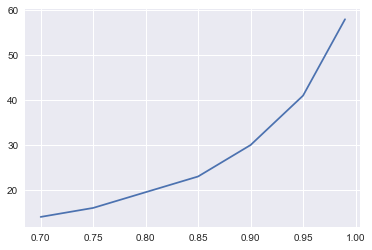

In [484]:
plt.plot([.7, .75, .85, .9, .95, .99], shapes)

### PCA and RandomForest

Slightly better at .46

In [302]:
scaler = MinMaxScaler()
pca = PCA(n_components=.99)
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [303]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [304]:
y_pred = pipe.predict(X_test)
scorer(y_test, y_pred) # Much better than base

0.4565628498392853

In [98]:
params = {'pca__n_components': n_values}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3)
grid.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] pca__n_components=0.7 ...........................................
[CV] .. pca__n_components=0.7, score=0.4536182586786902, total=   5.0s
[CV] pca__n_components=0.7 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] .. pca__n_components=0.7, score=0.4561632559301627, total=   5.3s
[CV] pca__n_components=0.7 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s


[CV] . pca__n_components=0.7, score=0.45327868417559386, total=   5.1s
[CV] pca__n_components=0.7725 ........................................
[CV]  pca__n_components=0.7725, score=0.4530939132968395, total=   5.3s
[CV] pca__n_components=0.7725 ........................................
[CV]  pca__n_components=0.7725, score=0.454119425100043, total=   5.1s
[CV] pca__n_components=0.7725 ........................................
[CV]  pca__n_components=0.7725, score=0.4542532621703818, total=   5.1s
[CV] pca__n_components=0.845 .........................................
[CV]  pca__n_components=0.845, score=0.4537359701001743, total=   6.5s
[CV] pca__n_components=0.845 .........................................
[CV]  pca__n_components=0.845, score=0.45226525360886677, total=   6.6s
[CV] pca__n_components=0.845 .........................................
[CV]  pca__n_components=0.845, score=0.4543870677683049, total=   6.7s
[CV] pca__n_components=0.9175 ........................................
[CV

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([ 0.7   ,  0.7725,  0.845 ,  0.9175,  0.99  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [99]:
grid.grid_scores_

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.45435, std: 0.00129, params: {'pca__n_components': 0.69999999999999996},
 mean: 0.45382, std: 0.00052, params: {'pca__n_components': 0.77249999999999996},
 mean: 0.45346, std: 0.00089, params: {'pca__n_components': 0.84499999999999997},
 mean: 0.45421, std: 0.00061, params: {'pca__n_components': 0.91749999999999998},
 mean: 0.45666, std: 0.00121, params: {'pca__n_components': 0.98999999999999999}]

In [100]:
grid.best_score_

0.45665534254361417

### Feature Importances

- Without PCA
- With PCA

In [305]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [306]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [307]:
fea_imp = sorted(list(zip(X.columns, pipe.named_steps['clf'].feature_importances_)), key=lambda x: x[1], reverse=True)
fea_imp

[('rating', 0.091115154464570164),
 ('online', 0.090709416920006086),
 ('max_rating', 0.09043626383667519),
 ('problem_solved', 0.087819767381378797),
 ('submission_count', 0.08698779779952015),
 ('follower_count', 0.08110480739672446),
 ('contribution', 0.042199125996538994),
 ('points', 0.038456668347511616),
 ('brute-force', 0.023241243154745288),
 ('math', 0.020182309010868642),
 ('greedy', 0.019751120927283768),
 ('implementation', 0.0196521574974017),
 ('sortings', 0.016294096296133632),
 ('constructive-algorithms', 0.015687356394535522),
 ('India', 0.013699081404101629),
 ('dp', 0.010534990698146148),
 ('strings', 0.010426449456828),
 ('binary-search', 0.0093739919392164476),
 ('data-structures', 0.0093037244116647745),
 ('number-theory', 0.0086714727328826048),
 ('level_A', 0.0084225024366372178),
 ('dfs-and-similar', 0.0079306590075230998),
 ('level_C', 0.0076030318193348132),
 ('Russia', 0.0074725514435924874),
 ('Bangladesh', 0.0073958136446195446),
 ('level_B', 0.0068837829

In [308]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
pca = PCA(.99)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [309]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [310]:
pipe.named_steps['clf'].feature_importances_

array([ 0.0134224 ,  0.0147486 ,  0.01300187,  0.01385312,  0.01342227,
        0.01158121,  0.01213482,  0.01225912,  0.01182517,  0.01338089,
        0.01354847,  0.01148386,  0.0111818 ,  0.01145252,  0.01134232,
        0.01131114,  0.01248192,  0.01153413,  0.01213198,  0.01109819,
        0.01059102,  0.01251066,  0.01146529,  0.01116549,  0.01078859,
        0.01027558,  0.01064726,  0.01115381,  0.01027254,  0.01037776,
        0.01034291,  0.00981038,  0.01050769,  0.0104385 ,  0.01063612,
        0.01013425,  0.01125224,  0.01057367,  0.01073816,  0.01116187,
        0.01038558,  0.0110101 ,  0.00979818,  0.01057966,  0.00995387,
        0.01173934,  0.01175619,  0.00980539,  0.01028435,  0.01085295,
        0.01010608,  0.01224345,  0.01068377,  0.01075973,  0.01056839,
        0.01012201,  0.01036975,  0.01007774,  0.01072372,  0.00932735,
        0.00970119,  0.01024917,  0.00984497,  0.01260736,  0.01024089,
        0.01181001,  0.01095931,  0.01249056,  0.01151656,  0.01

#### I have decided on the scaling and PCA given the improved results

### Xgboost

- Score is poorer than RandomForest at .41
- Predicts labels only 1, 2, 4 on test dataset

In [107]:
scaler = MinMaxScaler()
clf = XGBClassifier()
pca = PCA(.99)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [108]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, ...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [109]:
scorer(y_test, pipe.predict(X_test))

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.41834762759058552

### Optimizing scaler, pca, randomforest

.4656 slight improvement

In [115]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
pca = PCA(.99)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [123]:
np.linspace(.8, .999, 3)

array([ 0.8   ,  0.8995,  0.999 ])

In [124]:
params = {
    'pca__n_components': [.8, .9, .999],
    'clf__n_estimators': [10, 50, 100, 200]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3)
grid.fit(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__n_estimators=10, pca__n_components=0.8 .....................
[CV]  clf__n_estimators=10, pca__n_components=0.8, score=0.454126009622764, total=   5.8s
[CV] clf__n_estimators=10, pca__n_components=0.8 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV]  clf__n_estimators=10, pca__n_components=0.8, score=0.45755676206613904, total=   5.1s
[CV] clf__n_estimators=10, pca__n_components=0.8 .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s


[CV]  clf__n_estimators=10, pca__n_components=0.8, score=0.4541657244364834, total=   5.5s
[CV] clf__n_estimators=10, pca__n_components=0.9 .....................
[CV]  clf__n_estimators=10, pca__n_components=0.9, score=0.45400035113145226, total=   6.7s
[CV] clf__n_estimators=10, pca__n_components=0.9 .....................
[CV]  clf__n_estimators=10, pca__n_components=0.9, score=0.4546979157306966, total=   7.0s
[CV] clf__n_estimators=10, pca__n_components=0.9 .....................
[CV]  clf__n_estimators=10, pca__n_components=0.9, score=0.455517498221535, total=   7.2s
[CV] clf__n_estimators=10, pca__n_components=0.999 ...................
[CV]  clf__n_estimators=10, pca__n_components=0.999, score=0.45604942169045776, total=  12.3s
[CV] clf__n_estimators=10, pca__n_components=0.999 ...................
[CV]  clf__n_estimators=10, pca__n_components=0.999, score=0.4618442099546159, total=  12.1s
[CV] clf__n_estimators=10, pca__n_components=0.999 ...................
[CV]  clf__n_estimators

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 45.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [0.8, 0.9, 0.999], 'clf__n_estimators': [10, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [127]:
grid.best_params_

{'clf__n_estimators': 200, 'pca__n_components': 0.999}

In [128]:
grid.best_score_

0.46562020656385389

In [129]:
make_submission(grid.best_estimator_, test_df, 'random2.csv').head()

,ID,attempts_range
0,user_856_prob_5822,1
1,user_2642_prob_2334,2
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1
4,user_295_prob_6139,1


### Some More Tuning on rf

In [136]:
scaler = MinMaxScaler()
clf = RandomForestClassifier(n_estimators=10)
pca = PCA(.99)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [139]:
np.sqrt(45)

6.7082039324993694

In [146]:
params = {
    'clf__n_estimators': [10],
    'clf__min_samples_leaf': [10, 25, 50],
    'clf__max_features': [7, 9, 11]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.4674087955759651, total=  17.8s
[CV] clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46946412394217124, total=  19.8s
[CV] clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4706244731895974, total=  19.9s
[CV] clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4710287009216436, total=  20.0s
[CV] clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.459272950167496, total=  16.8s
[CV]  clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4592031009755273, total=  16.7s
[CV] clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10 
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.466113381339706, total=  19.1s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.46777462652917656, total=  19.1s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4582644042791071, total=  17.0s
[CV] clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46855456883799457, total=  26.0s
[CV] clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46953280921391227, total=  27.5s
[CV] clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46820076659357257, total=  27.3s
[CV] clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.46606668655947775, total=  23.6s
[CV] clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.4657974305520919, total=  24.5s
[CV] clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.45900855792527645, total=  21.9s
[CV] clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.46903908364920394, total=  24.6s
[CV] clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4598713860026606, total=  22.3s
[CV] clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.45816287569588304, total=  21.8s
[CV] clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4682091505149378, total=  32.3s
[CV]  clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4693865612046909, total=  31.0s
[CV] clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV] clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4710875664254888, total=  32.3s
[CV] clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.4652634194139722, total=  29.9s
[CV] clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.4651635190004085, total=  32.0s
[CV]  clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.4675431044477685, total=  32.0s
[CV] clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.46048808338840114, total=  27.6s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4610405328221471, total=  25.5s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4630464405800433, total=  17.1s


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__n_estimators': [10], 'clf__min_samples_leaf': [10, 25, 50], 'clf__max_features': [7, 9, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [147]:
grid.best_params_

{'clf__max_features': 7, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10}

In [148]:
grid.best_score_

0.47037241513769701

In [150]:
grid.grid_scores_

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.47037, std: 0.00066, params: {'clf__max_features': 7, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10},
 mean: 0.46710, std: 0.00071, params: {'clf__max_features': 7, 'clf__min_samples_leaf': 25, 'clf__n_estimators': 10},
 mean: 0.45891, std: 0.00046, params: {'clf__max_features': 7, 'clf__min_samples_leaf': 50, 'clf__n_estimators': 10},
 mean: 0.46876, std: 0.00056, params: {'clf__max_features': 9, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10},
 mean: 0.46697, std: 0.00147, params: {'clf__max_features': 9, 'clf__min_samples_leaf': 25, 'clf__n_estimators': 10},
 mean: 0.45901, std: 0.00070, params: {'clf__max_features': 9, 'clf__min_samples_leaf': 50, 'clf__n_estimators': 10},
 mean: 0.46956, std: 0.00118, params: {'clf__max_features': 11, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10},
 mean: 0.46599, std: 0.00110, params: {'clf__max_features': 11, 'clf__min_samples_leaf': 25, 'clf__n_estimators': 10},
 mean: 0.46152, std: 0.00110, params: {'clf__max_featu

In [149]:
make_submission(grid.best_estimator_, test_df, 'random3.csv').head()

,ID,attempts_range
0,user_856_prob_5822,1
1,user_2642_prob_2334,2
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1
4,user_295_prob_6139,1


In [152]:
params = {
    'clf__n_estimators': [10, 100],
    'clf__min_samples_leaf': [5, 10, 15],
    'clf__max_features': [5, 7, 9]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] clf__max_features=5, clf__min_samples_leaf=5, clf__n_estimators=10 
[CV] clf__max_features=5, clf__min_samples_leaf=5, clf__n_estimators=10 
[CV] clf__max_features=5, clf__min_samples_leaf=5, clf__n_estimators=10 
[CV] clf__max_features=5, clf__min_samples_leaf=5, clf__n_estimators=100 
[CV]  clf__max_features=5, clf__min_samples_leaf=5, clf__n_estimators=10, score=0.46541902706032406, total=  20.4s
[CV]  clf__max_features=5, clf__min_samples_leaf=5, clf__n_estimators=10, score=0.46915464905985405, total=  20.2s
[CV] clf__max_features=5, clf__min_samples_leaf=5, clf__n_estimators=100 
[CV] clf__max_features=5, clf__min_samples_leaf=5, clf__n_estimators=100 
[CV]  clf__max_features=5, clf__min_samples_leaf=5, clf__n_estimators=10, score=0.47054267335568667, total=  20.4s
[CV] clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, scor

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=100, score=0.4703331151377136, total= 2.4min
[CV] clf__max_features=5, clf__min_samples_leaf=15, clf__n_estimators=100 
[CV]  clf__max_features=5, clf__min_samples_leaf=15, clf__n_estimators=10, score=0.4691408445525778, total=  15.5s
[CV] clf__max_features=5, clf__min_samples_leaf=15, clf__n_estimators=100 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=100, score=0.4702313506143801, total= 2.4min
[CV] clf__max_features=5, clf__min_samples_leaf=15, clf__n_estimators=100 
[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=100, score=0.4715915812058684, total= 2.4min
[CV] clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=10, score=0.4664538825570036, total=  22.8s
[CV] clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=15, clf__n_estimators=100, score=0.4666182482452433, total= 2.3min
[CV] clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=10 
[CV]  clf__max_features=5, clf__min_samples_leaf=15, clf__n_estimators=100, score=0.4673729083423163, total= 2.3min
[CV] clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=100 
[CV]  clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=10, score=0.4667628548045029, total=  23.6s
[CV] clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=100 
[CV]  clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=10, score=0.4686280089985107, total=  22.9s
[CV] clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=100 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=15, clf__n_estimators=100, score=0.4693574039603986, total= 2.3min
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4685966133765951, total=  25.7s
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46938621996879293, total=  28.5s
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.47216568012594773, total=  25.8s
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.1min


[CV]  clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=100, score=0.4692037335787591, total= 4.2min
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100 
[CV]  clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=100, score=0.47173022534886644, total= 4.2min
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100 
[CV]  clf__max_features=7, clf__min_samples_leaf=5, clf__n_estimators=100, score=0.47261391902105526, total= 4.2min
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, score=0.4691865985039035, total=  18.9s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, score=0.470007737273785, total=  23.3s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, score=0.47128711632211484, total=  25.1s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=100 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100, score=0.4709504525903988, total= 3.7min
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=100 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100, score=0.47050915469972143, total= 3.4min
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=100 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100, score=0.4724713216938304, total= 3.3min
[CV] clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=10, score=0.46495131925007266, total=  26.7s
[CV] clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=100, score=0.4677657522181149, total= 3.0min
[CV] clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=10, score=0.4689629580133509, total=  29.6s
[CV] clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=100 
[CV]  clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=10, score=0.46918163503366744, total=  30.6s
[CV] clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=100 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=100, score=0.469122214650437, total= 3.1min
[CV] clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=100 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=100, score=0.46983386712198594, total= 3.3min
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4688680772728945, total=  30.5s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4695032874741463, total=  27.3s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4733271778983801, total=  25.0s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=100 
[CV]  clf__max_features=9, clf__min_samples_leaf=5, clf__n_estimators=100, score=0.469967751596558, total= 4.8min
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=100 
[CV]  clf__max_features=9, clf__min_samples_leaf=5, 

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=10, score=0.46935230078289214, total=  26.4s
[CV] clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=10, score=0.47150173932387185, total=  26.0s
[CV] clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=100 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=100, score=0.46991247284075616, total= 4.4min
[CV] clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=100 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=100, score=0.4705100915307064, total= 4.4min
[CV] clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=100 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=100, score=0.4724029913354754, total= 4.3min


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=100, score=0.46889521298935294, total= 3.5min


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=100, score=0.4692367401978111, total= 3.2min
[CV]  clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=100, score=0.4717388454496072, total= 2.5min


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 26.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__n_estimators': [10, 100], 'clf__min_samples_leaf': [5, 10, 15], 'clf__max_features': [5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [154]:
grid.best_params_

{'clf__max_features': 9, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 100}

In [155]:
grid.best_score_

0.47140353799163398

In [158]:
grid.grid_scores_

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.46837, std: 0.00216, params: {'clf__max_features': 5, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 10},
 mean: 0.47084, std: 0.00165, params: {'clf__max_features': 5, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 100},
 mean: 0.46918, std: 0.00174, params: {'clf__max_features': 5, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10},
 mean: 0.47072, std: 0.00062, params: {'clf__max_features': 5, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 100},
 mean: 0.46791, std: 0.00089, params: {'clf__max_features': 5, 'clf__min_samples_leaf': 15, 'clf__n_estimators': 10},
 mean: 0.46778, std: 0.00116, params: {'clf__max_features': 5, 'clf__min_samples_leaf': 15, 'clf__n_estimators': 100},
 mean: 0.46728, std: 0.00096, params: {'clf__max_features': 7, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 10},
 mean: 0.47118, std: 0.00145, params: {'clf__max_features': 7, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 100},
 mean: 0.47005, std: 0.00153, params: {'clf__max_feature

In [159]:
make_submission(grid.best_estimator_, test_df, 'random4.csv').head()

,ID,attempts_range
0,user_856_prob_5822,1
1,user_2642_prob_2334,2
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1
4,user_295_prob_6139,1


### XGB Time

In [164]:
scaler = MinMaxScaler()
clf = XGBClassifier(objective='multi:softmax', num_class=6, eval_metric)
pca = PCA(.99)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, ...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [165]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, ...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [166]:
scorer(y_test, pipe.predict(X_test))

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.41834762759058552

### Merging online and registration time

In [174]:
old_X = X.copy()

In [175]:
X.loc[:, 'time_diff'] = X['last_online_time_seconds'] - X['registration_time_seconds']

In [178]:
X.drop(['last_online_time_seconds', 'registration_time_seconds'], axis=1, inplace=True)

In [179]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
pca = PCA(.99)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [180]:
params = {
    'clf__n_estimators': [10]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__n_estimators=10 ............................................
[CV] clf__n_estimators=10 ............................................
[CV] clf__n_estimators=10 ............................................
[CV] .. clf__n_estimators=10, score=0.45579001311054496, total=  15.7s
[CV] .. clf__n_estimators=10, score=0.45683964072581545, total=  15.7s
[CV] ... clf__n_estimators=10, score=0.4568373909882803, total=  15.6s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__n_estimators': [10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [181]:
grid.best_score_

0.45648900143817916

### Countries

In [182]:
countries = pd.read_csv('data/train.csv')['country']
countries

0          Bangladesh
1                 NaN
2                 NaN
3           Indonesia
4               India
5                 NaN
6               Egypt
7              Brazil
8               India
9          Bangladesh
10              China
11            Vietnam
12            Romania
13            Czechia
14         Bangladesh
15                NaN
16              Spain
17              India
18              Japan
19                NaN
20             Russia
21                NaN
22         Bangladesh
23              India
24              India
25             Russia
26            Ukraine
27         Bangladesh
28            Romania
29                NaN
             ...     
155265          India
155266          India
155267          Egypt
155268            NaN
155269            NaN
155270          India
155271     Bangladesh
155272          India
155273         Russia
155274        Germany
155275            NaN
155276     Bangladesh
155277          India
155278          India
155279    

In [334]:
((countries.value_counts() / X.shape[0]) * 100)

India                     19.417882
Bangladesh                10.218616
Russia                     8.427831
China                      5.000805
Egypt                      3.343958
Kazakhstan                 2.287904
Vietnam                    1.982678
Brazil                     1.962716
Iran                       1.954989
Ukraine                    1.811391
Belarus                    1.583438
Japan                      1.463666
Syria                      1.298818
United States              1.297531
Romania                    1.222834
Poland                     1.024502
Uzbekistan                 0.854503
Taiwan                     0.750829
South Korea                0.737950
Croatia                    0.647799
Indonesia                  0.585982
Mexico                     0.545414
Jordan                     0.449467
Moldova                    0.402460
Georgia                    0.377346
Peru                       0.352233
Argentina                  0.339354
Hong Kong                  0

In [203]:
def inspect_country_attempt(y, countries, country):
    d = y[countries == country].value_counts()
    return (d / d.sum()) * 100

In [204]:
inspect_country_attempt(y, countries, 'India')

1    53.380866
2    30.897032
3     9.524125
4     3.299619
5     1.502238
6     1.396120
Name: attempts_range, dtype: float64

In [205]:
inspect_country_attempt(y, countries, 'Russia')

1    58.205990
2    28.384780
3     6.868888
4     3.025672
6     2.108802
5     1.405868
Name: attempts_range, dtype: float64

In [206]:
inspect_country_attempt(y, countries, 'Bangladesh')

1    54.200013
2    30.342177
3     8.834835
4     3.459575
6     1.701430
5     1.461970
Name: attempts_range, dtype: float64

In [207]:
inspect_country_attempt(y, countries, 'China')

1    51.197528
2    31.071337
3     9.747618
4     3.566830
6     2.446562
5     1.970126
Name: attempts_range, dtype: float64

In [200]:
y[countries == 'Poland'].value_counts()

1    867
2    472
3    137
4     51
6     42
5     22
Name: attempts_range, dtype: int64

### Back to rf after adding country data

In [320]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
pca = PCA(.99)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [321]:
params = {
    'pca__n_components': [.85, .9, .95, .99]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] pca__n_components=0.85 ..........................................
[CV] pca__n_components=0.85 ..........................................
[CV] pca__n_components=0.85 ..........................................
[CV] pca__n_components=0.9 ...........................................
[CV] . pca__n_components=0.85, score=0.4500191525126995, total=  23.3s
[CV]  pca__n_components=0.85, score=0.45043305870242756, total=  23.5s
[CV] pca__n_components=0.9 ...........................................
[CV] pca__n_components=0.9 ...........................................
[CV] . pca__n_components=0.85, score=0.4485221795899613, total=  24.0s
[CV] pca__n_components=0.95 ..........................................
[CV] . pca__n_components=0.9, score=0.44887782785275426, total=  27.9s
[CV] pca__n_components=0.95 ..........................................
[CV] . pca__n_components=0.9, score=0.44992308672642023, total=  25.6s
[CV] pca__n_compo

[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.4min remaining:   17.3s


[CV]  pca__n_components=0.99, score=0.44991562956687664, total=  31.4s
[CV] . pca__n_components=0.99, score=0.4473701383365177, total=  29.7s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'pca__n_components': [0.85, 0.9, 0.95, 0.99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [322]:
grid.best_score_

0.45106996063864307

In [323]:
grid.best_params_

{'pca__n_components': 0.95}

In [325]:
params = {
    'pca__n_components': [.9, .95, .99],
    'clf__n_estimators': [10],
    'clf__min_samples_leaf': [10, 20, 30],
    'clf__max_features': [5, 7, 9]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV] clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV] clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV] clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.46251039986859266, total=  17.1s
[CV] clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.462129763157214, total=  17.3s
[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.46175507466594345, total=  17.1s
[CV] clf__max_features=5, clf__min_sa

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.46222391527438556, total=  19.2s
[CV] clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.46414436581915414, total=  20.2s
[CV] clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9 
[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.99, score=0.45622523918169205, total=  19.7s
[CV] clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9 
[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.99, score=0.4566242806199507, total=  19.8s
[CV] clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.45737998337043223, total=  15.7s
[CV] clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.4581587095559266, total=  15.7s
[CV] clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.4606036308944913, total=  15.5s
[CV]  clf__max_features=5, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.99, score=0.45696609007303546, total=  16.6s
[CV] clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 
[CV] clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.45590418756172113, total=  15.2s
[CV] clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.4587891087206208, total=  14.8s
[CV]  clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.45752958896773144, total=  15.2s
[CV] clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 
[CV] clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9 
[CV]  clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.4467660647916996, total=  15.0s
[CV] clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9, score=0.4524940117376481, total=  14.9s
[CV] clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9 
[CV]  clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.4522100836285217, total=  15.1s
[CV] clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9, score=0.4538982964012923, total=  15.0s
[CV] clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=5, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.45111657024025215, total=  16.0s
[CV] clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9, score=0.4550522802074428, total=  14.7s
[CV] clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95, score=0.4514413238828505, total=  14.6s
[CV] clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95, score=0.45319541569851257, total=  15.0s
[CV] clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95, score=0.45223749122370116, total=  14.7s
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99, score=0.44303422711761725, total=  15.1s
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV]  clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99, score=0.4455848065369625, total=  15.0s
[CV]  clf__max_features=5, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99, score=0.44663752064985196, total=  14.9s
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.4597942198483239, total=  22.0s
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, 

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.99, score=0.46017868151541, total=  24.3s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.4604761678998119, total=  19.3s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.4576757350099149, total=  20.0s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.45856846702687504, total=  18.8s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.4589583995729423, total=  19.2s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.45761389285456544, total=  19.4s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.4536195874480816, total=  19.0s
[CV] clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9 
[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.46145983658862544, total=  19.5s
[CV] clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.45013801601739034, total=  19.1s
[CV] clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.4531333355882765, total=  18.3s
[CV]  clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9, score=0.4524994379060747, total=  17.8s
[CV] clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95 
[CV] clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9, score=0.4547619398202581, total=  18.3s
[CV] clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9, score=0.45507855894997123, total=  18.1s
[CV] clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95, score=0.4530643360418999, total=  18.3s
[CV] clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95, score=0.4543305606875592, total=  18.6s
[CV] clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95, score=0.4534985167710672, total=  18.6s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99, score=0.4457823490878262, total=  18.4s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99, score=0.4480946849954826, total=  18.7s
[CV]  clf__max_features=7, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99, score=0.4477777920655442, total=  18.7s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.4599654749207051, total=  25.5s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.46318448214295604, total=  25.9s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, c

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.99, score=0.45589967884984794, total=  24.7s
[CV] clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.99, score=0.46147113415954266, total=  24.8s
[CV] clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.99, score=0.4600232425203338, total=  24.4s
[CV] clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.45740255912884703, total=  24.0s
[CV] clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.4605539722949595, total=  23.1s
[CV] clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.4573961447313614, total=  24.7s
[CV] clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.4572861917188619, total=  23.9s
[CV] clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.45865944430594235, total=  23.2s
[CV] clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.4576648358561938, total=  23.1s
[CV] clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.45460019757686393, total=  23.9s
[CV] clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.4551627848974068, total=  22.8s
[CV] clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.45465053992717946, total= 3.1min
[CV] clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9, score=0.45640780812425275, total= 3.2min
[CV] clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9, score=0.45774781518190655, total= 3.2min
[CV] clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.9, score=0.45802361436239675, total= 3.2min
[CV] clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95, score=0.45480728583729413, total=  31.6s
[CV] clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95, score=0.4570423505784837, total=  31.9s
[CV] clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.95, score=0.45617967246225405, total=  29.9s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99, score=0.4494152327504509, total=  30.4s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99, score=0.4466174065112603, total=  27.5s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=30, clf__n_estimators=10, pca__n_components=0.99, score=0.4505560767515718, total=  17.1s


[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 10.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'pca__n_components': [0.9, 0.95, 0.99], 'clf__n_estimators': [10], 'clf__min_samples_leaf': [10, 20, 30], 'clf__max_features': [5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [327]:
grid.best_score_

0.46280575942191055

In [328]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [329]:
grid.best_params_

{'clf__max_features': 9,
 'clf__min_samples_leaf': 10,
 'clf__n_estimators': 10,
 'pca__n_components': 0.95}

In [331]:
make_submission(grid.best_estimator_, test_df, 'random5.csv').head()

,ID,attempts_range
0,user_856_prob_5822,1
1,user_2642_prob_2334,2
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1
4,user_295_prob_6139,1


### Feature Selection again

In [332]:
X.head()

,points,submission_count,problem_solved,contribution,follower_count,max_rating,rating,level_A,level_B,level_C,...,United Kingdom,United States,Uzbekistan,Venezuela,Vietnam,rank_advanced,rank_beginner,rank_expert,rank_intermediate,online
0,1000.0,53,47,0,1,307.913,206.709,0,1,0,...,0,0,0,0,0,0,1,0,0,71522843
1,1500.0,133,118,0,0,324.255,235.378,0,0,1,...,0,0,0,0,0,0,1,0,0,47535708
2,500.0,50,44,0,7,343.177,229.358,1,0,0,...,0,0,0,0,0,0,1,0,0,31228669
3,500.0,271,233,23,40,436.927,399.083,1,0,0,...,0,0,0,0,0,0,0,0,1,57438471
4,2000.0,155,135,0,80,492.546,472.190,0,0,0,...,0,0,0,0,0,1,0,0,0,67697192


In [360]:
list(((countries.value_counts() / X.shape[0]) * 100).nlargest(16).index)

['India',
 'Bangladesh',
 'Russia',
 'China',
 'Egypt',
 'Kazakhstan',
 'Vietnam',
 'Brazil',
 'Iran',
 'Ukraine',
 'Belarus',
 'Japan',
 'Syria',
 'United States',
 'Romania',
 'Poland']

### Let's start by computing feature importances

In [361]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [365]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [368]:
fea_imp = sorted(zip(X.columns, pipe.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True)
fea_imp

[('online', 0.091428482614776832),
 ('rating', 0.091069965203144379),
 ('max_rating', 0.090338545579759982),
 ('submission_count', 0.087217981294290051),
 ('problem_solved', 0.086978769277144388),
 ('follower_count', 0.082070945390940259),
 ('contribution', 0.041471129064877821),
 ('points', 0.034982777712559053),
 ('brute-force', 0.025130922885063012),
 ('implementation', 0.023602879474024129),
 ('math', 0.021557223747094241),
 ('greedy', 0.021135356875393297),
 ('sortings', 0.016499400883552912),
 ('constructive-algorithms', 0.015593651357642171),
 ('India', 0.01291819765204077),
 ('strings', 0.011364091841411073),
 ('data-structures', 0.010889207331630216),
 ('dp', 0.010822618666587123),
 ('binary-search', 0.0101583435565168),
 ('number-theory', 0.0085779874519857462),
 ('level_A', 0.0085190129466662916),
 ('Bangladesh', 0.0077187319224886267),
 ('dfs-and-similar', 0.0072266796695201656),
 ('Russia', 0.0068501030869789984),
 ('level_C', 0.0060799919639886717),
 ('China', 0.006053615

In [373]:
fea_imp = pd.DataFrame(fea_imp, columns=['fea', 'imp'])
fea_imp.head()

,fea,imp
0,online,0.091428
1,rating,0.091070
2,max_rating,0.090339
3,submission_count,0.087218
4,problem_solved,0.086979


In [374]:
fea_imp.head()

,fea,imp
0,online,0.091428
1,rating,0.091070
2,max_rating,0.090339
3,submission_count,0.087218
4,problem_solved,0.086979


In [376]:
fea_imp.shape

(142, 2)

In [386]:
fea_0001 = list(fea_imp[(fea_imp.imp > .0001)].fea)
len(fea_0001)

131

In [387]:
fea_001 = list(fea_imp[(fea_imp.imp > .001)].fea)
len(fea_001)

76

In [390]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
pca = PCA()
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [391]:
pipe.fit(X_train[fea_001], y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [392]:
scorer(y_test, pipe.predict(X_test[fea_001]))

0.45649578533229496

### Re tuning Rf

In [490]:
scaler = MinMaxScaler()
clf = RandomForestClassifier(n_estimators=10)
pca = PCA(.99)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [477]:
params = {
    'clf__n_estimators': [10],
    'clf__min_samples_leaf': [10, 25, 50],
    'clf__max_features': [7, 9, 11]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.4558700969099271, total=  28.4s
[CV] clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46614855802255273, total=  31.8s
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46183149390391576, total=  32.1s
[CV] clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46233637472615746, total=  32.7s
[CV] clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.45605355718743046, total=  24.3s
[CV] clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4461461474231528, total=  21.4s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4490833236400309, total=  22.1s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.45815426092844663, total=  24.2s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4489532840699341, total=  24.1s
[CV] clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46056699045750693, total=  35.1s
[CV] clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4638051575675123, total=  36.2s
[CV] clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4653311689355844, total=  35.1s
[CV] clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.45554668067405224, total=  28.5s
[CV] clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.4566376985335004, total=  24.4s
[CV] clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4488949411506483, total=  22.8s
[CV] clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.455620589604663, total=  24.7s
[CV] clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4485729980625095, total=  23.5s
[CV] clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4523006429240313, total=  26.3s
[CV] clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4626712388968635, total=  37.5s
[CV] clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.46435436201245234, total=  37.8s
[CV] clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10 
[CV]  clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4654977955810323, total=  38.9s
[CV] clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.45853229449513094, total=  33.4s
[CV] clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.45855336403487773, total=  33.0s
[CV] clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=25, clf__n_estimators=10, score=0.4598466602482864, total=  32.8s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.44934628163168194, total=  24.8s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4488177667770976, total=  21.9s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=11, clf__min_samples_leaf=50, clf__n_estimators=10, score=0.4506318250670051, total=  15.8s


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_dept...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__n_estimators': [10], 'clf__min_samples_leaf': [10, 25, 50], 'clf__max_features': [7, 9, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [485]:
grid.best_score_

0.46417443645734296

In [486]:
grid.best_params_

{'clf__max_features': 11, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10}

In [514]:
X.head()

,points,submission_count,problem_solved,contribution,follower_count,max_rating,rating,level_A,level_B,level_C,...,Japan,Syria,United States,Romania,Poland,rank_advanced,rank_beginner,rank_expert,rank_intermediate,online
0,1000.0,53,47,0,1,307.913,206.709,0,1,0,...,0,0,0,0,0,0,1,0,0,71522843
1,1500.0,133,118,0,0,324.255,235.378,0,0,1,...,0,0,0,0,0,0,1,0,0,47535708
2,500.0,50,44,0,7,343.177,229.358,1,0,0,...,0,0,0,0,0,0,1,0,0,31228669
3,500.0,271,233,23,40,436.927,399.083,1,0,0,...,0,0,0,0,0,0,0,0,1,57438471
4,2000.0,155,135,0,80,492.546,472.190,0,0,0,...,0,0,0,0,0,1,0,0,0,67697192


### Again feature selection

In [494]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [495]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [496]:
fea_imp = sorted(zip(X.columns, pipe.named_steps['clf'].feature_importances_), key=lambda x: x[1], reverse=True)
fea_imp

[('online', 0.095818358306348925),
 ('rating', 0.094262244861964509),
 ('max_rating', 0.094179886179421107),
 ('problem_solved', 0.091417660731626688),
 ('submission_count', 0.090446550849568402),
 ('follower_count', 0.084612006951894553),
 ('contribution', 0.043546478965886939),
 ('points', 0.036931673258731736),
 ('brute-force', 0.027045774437895843),
 ('math', 0.02049307313765206),
 ('greedy', 0.019867722176656739),
 ('sortings', 0.016183654330443619),
 ('constructive-algorithms', 0.015783307613504223),
 ('implementation', 0.015500856033773994),
 ('India', 0.013221982486372788),
 ('strings', 0.012213651776576137),
 ('binary-search', 0.010852425720041418),
 ('dp', 0.0099767050447891158),
 ('data-structures', 0.009663410575067935),
 ('number-theory', 0.0094842134501607073),
 ('level_A', 0.0088234945971799976),
 ('dfs-and-similar', 0.0078391053628985418),
 ('Bangladesh', 0.0075076867344902),
 ('level_C', 0.0074769928495857672),
 ('level_B', 0.0073821060449406183),
 ('Russia', 0.0073383

In [503]:
fea_imp = pd.DataFrame(fea_imp, columns='fea imp'.split())
fea_imp.head()

,fea,imp
0,online,0.095818
1,rating,0.094262
2,max_rating,0.094180
3,problem_solved,0.091418
4,submission_count,0.090447


### RFE

- remove half features
- optimize

In [508]:
clf = RandomForestClassifier()
rfe = RFE(clf)

In [509]:
X_rfe = rfe.fit_transform(X, y)

In [512]:
X_rfe.shape

(155295, 39)

In [513]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [515]:
params = {
    'clf__n_estimators': [10],
    'clf__min_samples_leaf': [10],
    'clf__max_features': [7, 9]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.43410182465359376, total=   5.2s
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4354108062191033, total=   5.4s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.43439711741421544, total=   5.2s


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    6.6s remaining:   13.2s


[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.44162380398034123, total=   5.9s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.44269182283823144, total=   3.9s
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4410317217458779, total=   4.0s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   11.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_..._jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__n_estimators': [10], 'clf__min_samples_leaf': [10], 'clf__max_features': [7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [522]:
grid.best_score_

0.44178244645675752

In [533]:
fea_imp[(fea_imp.imp > .01)].fea

0                      online
1                      rating
2                  max_rating
3              problem_solved
4            submission_count
5              follower_count
6                contribution
7                      points
8                 brute-force
9                        math
10                     greedy
11                   sortings
12    constructive-algorithms
13             implementation
14                      India
15                    strings
16              binary-search
Name: fea, dtype: object

In [537]:
X_17 = X[fea_imp[(fea_imp.imp > .01)].fea]

In [539]:
X_17_train, X_17_test, y_17_train, y_17_test = train_test_split(X_17, y)
X_17_train.shape, X_17_test.shape

((116471, 17), (38824, 17))

In [536]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [540]:
pipe.fit(X_17_train, y_17_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

scorer(y_17_test, pipe.predict(X_17_test))

In [544]:
X_17.head()

,online,rating,max_rating,problem_solved,submission_count,follower_count,contribution,points,brute-force,math,greedy,sortings,constructive-algorithms,implementation,India,strings,binary-search
0,71522843,206.709,307.913,47,53,1,0,1000.0,0,0,0,0,0,0,0,1,0
1,47535708,235.378,324.255,118,133,0,0,1500.0,1,0,0,0,0,0,0,0,0
2,31228669,229.358,343.177,44,50,7,0,500.0,0,0,0,0,0,1,0,0,0
3,57438471,399.083,436.927,233,271,40,23,500.0,1,0,0,0,0,1,0,0,0
4,67697192,472.190,492.546,135,155,80,0,2000.0,0,0,0,0,0,0,1,0,0


### Let's try an average of problem_solved and submission_count

In [546]:
X.loc[:, 'accuracy'] = X.problem_solved / X.submission_count
X.head()

,points,submission_count,problem_solved,contribution,follower_count,max_rating,rating,level_A,level_B,level_C,...,Syria,United States,Romania,Poland,rank_advanced,rank_beginner,rank_expert,rank_intermediate,online,accuracy
0,1000.0,53,47,0,1,307.913,206.709,0,1,0,...,0,0,0,0,0,1,0,0,71522843,0.886792
1,1500.0,133,118,0,0,324.255,235.378,0,0,1,...,0,0,0,0,0,1,0,0,47535708,0.887218
2,500.0,50,44,0,7,343.177,229.358,1,0,0,...,0,0,0,0,0,1,0,0,31228669,0.880000
3,500.0,271,233,23,40,436.927,399.083,1,0,0,...,0,0,0,0,0,0,0,1,57438471,0.859779
4,2000.0,155,135,0,80,492.546,472.190,0,0,0,...,0,0,0,0,1,0,0,0,67697192,0.870968


In [547]:
X.accuracy.describe()

count    155295.000000
mean          0.868627
std           0.084101
min           0.116438
25%           0.826507
50%           0.885714
75%           0.928315
max           1.000000
Name: accuracy, dtype: float64

### rf test on dataframe now with accuracy

In [561]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [563]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [570]:
fea_imp = sorted(list(zip(X.columns, pipe.named_steps['clf'].feature_importances_)), key=lambda x: x[1], reverse=True)

In [573]:
fea_imp = pd.DataFrame(fea_imp, columns='fea imp'.split())

In [574]:
fea_imp.head()

,fea,imp
0,online,0.116691
1,rating,0.115517
2,max_rating,0.113637
3,accuracy,0.106905
4,follower_count,0.103617


In [578]:
scaler = MinMaxScaler()
pca = PCA(n_components=.9)
clf = RandomForestClassifier(n_jobs=-1)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [586]:
params = {
    'pca__n_components': [.9, .95, .99],
    'clf__n_estimators': [10],
    'clf__min_samples_leaf': [10, 15, 20],
    'clf__max_features': [7, 9, 11]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.46066526784497447, total=  20.7s
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.46333616331223726, total=  21.6s
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.460344306165467, total=  21.9s
[CV] clf__max_features=7, clf__min_s

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.99, score=0.4644500277694802, total=  20.1s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.9, score=0.4598711918425, total=  19.7s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.9, score=0.4614053024627334, total=  19.7s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.9, score=0.46240499601664464, total=  20.0s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95, score=0.4587837384847252, total=  18.8s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95, score=0.45991420219724655, total=  19.4s
[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95, score=0.46177976415878985, total=  19.2s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.99 
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.99, score=0.457866833646564, total=  20.0s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.99, score=0.46238317039819, total=  18.2s


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.4577255672371174, total=  18.1s
[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.99, score=0.4623976252358685, total=  18.2s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.45961112680990324, total=  17.6s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.9, score=0.4632021394761836, total=  18.9s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.4609574684322491, total=  19.1s
[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.457735557896101, total=  19.7s
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 
[CV] clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99 
[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.95, score=0.45925639430671583, total=  20.0s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.45646424566536914, total=  19.5s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.45938538582624705, total=  20.1s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9 
[CV]  clf__max_features=7, clf__min_samples_leaf=20, clf__n_estimators=10, pca__n_components=0.99, score=0.45954700845888313, total=  20.2s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.4606832891221464, total=  24.4s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.9, score=0.46289476875427926, total=  25.2s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=9, clf__min_samples_leaf=10,

KeyboardInterrupt: 

In [580]:
grid.best_params_

{'clf__max_features': 9, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10}

In [581]:
grid.best_score_

0.46352845850349927

In [582]:
grid.grid_scores_

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.46155, std: 0.00103, params: {'clf__max_features': 7, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10},
 mean: 0.46353, std: 0.00169, params: {'clf__max_features': 9, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10}]

In [584]:
make_submission(grid.best_estimator_, test_df, 'random6.csv').head()

,ID,attempts_range
0,user_856_prob_5822,1
1,user_2642_prob_2334,1
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1
4,user_295_prob_6139,2


### Features

In [588]:
X['level_A'].value_counts()

0    95577
1    59718
Name: level_A, dtype: int64

In [589]:
X['level_B'].value_counts()

0    114876
1     40419
Name: level_B, dtype: int64

In [590]:
X['level_C'].value_counts()

0    129419
1     25876
Name: level_C, dtype: int64

In [591]:
X['level_D'].value_counts()

0    141370
1     13925
Name: level_D, dtype: int64

In [600]:
X[['level_A', 'level_B']].sum(axis=1).corr(y)

-0.16071473983852708

In [621]:
X[['level_A', 'level_B']].sum(axis=1).value_counts()

1    100137
0     55158
dtype: int64

In [604]:
X[['level_C']].sum(axis=1).corr(y)

0.084698007836841963

In [618]:
X[['level_C', 'level_D', 'level_E', 'level_F']].sum(axis=1).corr(y)

0.16014975797281214

In [622]:
X[['level_C', 'level_D', 'level_E', 'level_F']].sum(axis=1).value_counts()

0    106979
1     48316
dtype: int64

In [635]:
X[['level_G', 'level_H', 'level_I', 'level_J', 'level_K', 'level_L', 'level_M', 'level_N', 'level_O']].sum(axis=1).corr(y)

0.013502938910366458

In [634]:
X[['level_G', 'level_H', 'level_I', 'level_J', 'level_K', 'level_L', 'level_M', 'level_N', 'level_O']].sum(axis=1).value_counts()

0    148453
1      6842
dtype: int64

### Back to model

In [647]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [648]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [649]:
fea_imp = sorted(list(zip(X.columns, pipe.named_steps['clf'].feature_importances_)), key=lambda x: x[1], reverse=True)
fea_imp = pd.DataFrame(fea_imp, columns='fea imp'.split())

In [651]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [652]:
scorer(y_test, pipe.predict(X_test))

0.45352798688030849

In [654]:
X.head()

,points,contribution,follower_count,max_rating,rating,*special,2-sat,binary-search,bitmasks,brute-force,...,Poland,rank_advanced,rank_beginner,rank_expert,rank_intermediate,online,accuracy,level_1,level_2,level_3
0,1000.0,0,1,307.913,206.709,0,0,0,0,0,...,0,0,1,0,0,71522843,-6,1,0,0
1,1500.0,0,0,324.255,235.378,0,0,0,0,1,...,0,0,1,0,0,47535708,-15,0,1,0
2,500.0,0,7,343.177,229.358,0,0,0,0,0,...,0,0,1,0,0,31228669,-6,1,0,0
3,500.0,23,40,436.927,399.083,0,0,0,0,1,...,0,0,0,0,1,57438471,-38,1,0,0
4,2000.0,0,80,492.546,472.190,0,0,0,0,0,...,0,1,0,0,0,67697192,-20,0,1,0


In [655]:
X.rank_beginner.corr(y)

0.028014606453849612

In [656]:
X.rank_intermediate.corr(y)

-0.0044873693536622867

In [657]:
X.rank_expert.corr(y)

-0.031778894549057288

In [658]:
X.rank_advanced.corr(y)

-0.013459131656542129

In [671]:
X[['rank_beginner']].sum(axis=1).corr(y)

0.028014606453849612

In [672]:
X[['rank_beginner']].sum(axis=1).value_counts()

0    102099
1     53196
dtype: int64

In [667]:
X[['rank_expert', 'rank_advanced', 'rank_intermediate']].sum(axis=1).corr(y)

-0.028014606453849608

In [673]:
X[['rank_expert', 'rank_advanced', 'rank_intermediate']].sum(axis=1).value_counts()

1    102099
0     53196
dtype: int64

### feature

In [684]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
steps = [('scaler', scaler), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [685]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [686]:
fea_imp = sorted(list(zip(X.columns, pipe.named_steps['clf'].feature_importances_)), key=lambda x: x[1], reverse=True)
fea_imp = pd.DataFrame(fea_imp, columns='fea imp'.split())

In [690]:
fea_imp[fea_imp.imp < .001]

,fea,imp
58,string-suffix-structures,0.000863
59,2-sat,0.000440
60,meet-in-the-middle,0.000435
61,fft,0.000355
62,schedules,0.000235
63,chinese-remainder-theorem,0.000149


In [691]:
X['string-suffix-structures'].value_counts()

0    154903
1       392
Name: string-suffix-structures, dtype: int64

In [692]:
X['2-sat'].value_counts()

0    154898
1       397
Name: 2-sat, dtype: int64

In [693]:
X['meet-in-the-middle'].value_counts()

0    155050
1       245
Name: meet-in-the-middle, dtype: int64

In [695]:
X[fea_imp[fea_imp.imp < .001].fea].describe()

,string-suffix-structures,2-sat,meet-in-the-middle,fft,schedules,chinese-remainder-theorem
count,155295.000000,155295.000000,155295.000000,155295.000000,155295.000000,155295.000000
mean,0.002524,0.002556,0.001578,0.000850,0.000515,0.000419
std,0.050178,0.050497,0.039688,0.029142,0.022691,0.020454
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [711]:
X[fea_imp[fea_imp.imp < .001].fea].sum(axis=1).corr(y)

0.038058264885308016

In [719]:
X[fea_imp[fea_imp.imp < .001].fea].sum(axis=1).value_counts()

0    153984
1      1311
dtype: int64

In [722]:
list(fea_imp[fea_imp.imp < .001].fea)

['string-suffix-structures',
 '2-sat',
 'meet-in-the-middle',
 'fft',
 'schedules',
 'chinese-remainder-theorem']

In [734]:
scaler = MinMaxScaler()
pca = PCA(n_components=.9)
clf = RandomForestClassifier(n_jobs=-1)
steps = [('scaler', scaler), ('pca', pca), ('clf', clf)]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [737]:
params = {
    #'pca__n_components': [.9, .95, .99],
    'clf__n_estimators': [10],
    'clf__min_samples_leaf': [10],
    'clf__max_features': [7, 9, 11, 13]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.45816412330751366, total=  16.2s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4610663180504791, total=  16.6s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4632943892150305, total=  16.7s
[CV] clf__max_features=11, clf__min_samples_leaf=10, clf__n_estimators=10 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, 

[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.2min remaining:   13.9s


[CV]  clf__max_features=13, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4622941941637182, total=  27.6s
[CV]  clf__max_features=13, clf__min_samples_leaf=10, clf__n_estimators=10, score=0.4634466934105568, total=  25.2s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__n_estimators': [10], 'clf__min_samples_leaf': [10], 'clf__max_features': [7, 9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [738]:
grid.best_params_

{'clf__max_features': 13, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 10}

In [739]:
grid.best_score_

0.46170575601037495

In [740]:
make_submission(grid.best_estimator_, test_df, 'random7.csv').head()

,ID,attempts_range
0,user_856_prob_5822,2
1,user_2642_prob_2334,2
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1
4,user_295_prob_6139,2


In [741]:
params = {
    'pca__n_components': [.95],
    'clf__n_estimators': [10],
    'clf__min_samples_leaf': [10, 15],
    'clf__max_features': [7, 9]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.46263330527885893, total=  18.9s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.45944737487073883, total=  19.5s
[CV] clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=1

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95, score=0.46257897089976163, total=  18.2s
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95, score=0.45912236262634626, total=  19.5s
[CV] clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.4610179623441318, total=  22.1s
[CV] clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95 
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.459666977445328, total=  22.6s
[CV] clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95 


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.46265006966549554, total=  24.2s
[CV]  clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95, score=0.45806011323773366, total=  23.8s


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.1min remaining:   13.1s
/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95, score=0.46288500484698425, total=  21.7s
[CV]  clf__max_features=9, clf__min_samples_leaf=15, clf__n_estimators=10, pca__n_components=0.95, score=0.4611914446260652, total=  22.2s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'pca__n_components': [0.95], 'clf__n_estimators': [10], 'clf__min_samples_leaf': [10, 15], 'clf__max_features': [7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [742]:
grid.best_score_

0.46188196922400793

In [746]:
params = {
    'pca__n_components': [.95],
    'clf__n_estimators': [10, 100],
    'clf__min_samples_leaf': [10],
    'clf__max_features': [7, 9]
}
grid = GridSearchCV(pipe, param_grid=params, scoring=grid_scorer, verbose=3, n_jobs=-1)
grid.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95 
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.458325001752677, total=  17.7s
[CV] clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.46076452951768687, total=  18.3s
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=10, pca__n_components=0.95, score=0.4631934783684783, total=  18.2s
[CV] clf__max_features=7, clf__

/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100, pca__n_components=0.95, score=0.46199162251713144, total= 2.4min
[CV] clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=100, pca__n_components=0.95 
[CV]  clf__max_features=7, clf__min_samples_leaf=10, clf__n_estimators=100, pca__n_components=0.95, score=0.46413185703886123, total= 2.4min
[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=100, pca__n_components=0.95, score=0.45885133964891567, total= 2.9min


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  4.5min remaining:   54.2s


[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=100, pca__n_components=0.95, score=0.4602878254195877, total= 2.5min


/Users/sartajsingh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__max_features=9, clf__min_samples_leaf=10, clf__n_estimators=100, pca__n_components=0.95, score=0.4636913816526531, total= 2.3min


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'pca__n_components': [0.95], 'clf__n_estimators': [10, 100], 'clf__min_samples_leaf': [10], 'clf__max_features': [7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=3)

In [747]:
grid.best_score_

0.46163807504282606

In [748]:
grid.best_params_

{'clf__max_features': 7,
 'clf__min_samples_leaf': 10,
 'clf__n_estimators': 100,
 'pca__n_components': 0.95}

In [749]:
make_submission(grid.best_estimator_, test_df, 'random8.csv').head()

,ID,attempts_range
0,user_856_prob_5822,1
1,user_2642_prob_2334,2
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1
4,user_295_prob_6139,1
